Projet AARN SII - 2022/2023

Travail réalisé par:
* BELKACEMI Meriem
* LABRI Ahlem
* MAYOUF Lotfi



### Importations

In [ ]:
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import nltk
from collections import Counter
from nltk.stem import PorterStemmer
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM , Dropout ,MaxPooling1D,Flatten,Conv1D
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc

# Importing Data from Kaggle

### Using locally imported data

In [ ]:
def get_data(path):
    data = []
    files = os.listdir(path)
    for file in files:
        f = open(path+file, encoding = "ISO-8859-1")
        words_list = f.read()
        data.append(words_list)
        f.close()
    return data

In [ ]:
easy_ham = get_data("./data/easy_ham/easy_ham/")

hard_ham = get_data("./data/hard_ham/hard_ham/")

ham = easy_ham + hard_ham

spam = get_data("./data/spam_2/spam_2/")

### Using Kaggle from Google Colab

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"meriembelkacemi","key":"6e8dcfecbede21f37016291d0938b770"}'}

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d beatoa/spamassassin-public-corpus

 99% 11.0M/11.1M [00:00<00:00, 113MB/s]
100% 11.1M/11.1M [00:00<00:00, 114MB/s]


In [ ]:
!unzip /content/spamassassin-public-corpus.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: easy_ham/easy_ham/0847.00a64e95e9b26dd792571a8213a90c78  
  inflating: easy_ham/easy_ham/0848.ef1b9b43e194c1650d7722ffcc7b20ad  
  inflating: easy_ham/easy_ham/0849.84e6b16e331d3e5bcd798ca0f5374624  
  inflating: easy_ham/easy_ham/0850.37218bc58cdc1cf2502010a098c77965  
  inflating: easy_ham/easy_ham/0851.b7c6fc9da1800afe4eed1a0807dbdccc  
  inflating: easy_ham/easy_ham/0852.cab2623799815a32681d15c6c82a41c5  
  inflating: easy_ham/easy_ham/0853.79c912aba9155510575bfec3b8123f8e  
  inflating: easy_ham/easy_ham/0854.6fc80acdb73b0ab60c3f316f646c0546  
  inflating: easy_ham/easy_ham/0855.5b51f55bb80a0889f3d7071b99f8cdef  
  inflating: easy_ham/easy_ham/0856.53c342f04272fa2b9c1f63829301e96b  
  inflating: easy_ham/easy_ham/0857.c5290c6dee60d45314e519678e96735c  
  inflating: easy_ham/easy_ham/0858.23f1e5976dae32b0061a6e206aa73241  
  inflating: easy_ham/easy_ham/0859.c5de7d55c638b365941e5077d598ff6a  

Tout d'abord, les fichiers d'e-mails sont lus à partir des catégories "easy ham", "hard ham" et "spam".

In [ ]:
def get_data(path):
    data = []
    files = os.listdir(path)
    for file in files:
        f = open(path+file, encoding = "ISO-8859-1")
        words_list = f.read()
        data.append(words_list)
        f.close()
    return data

In [ ]:
easy_ham = get_data("/content/easy_ham/easy_ham/")

hard_ham = get_data("/content/hard_ham/hard_ham/")

ham = easy_ham + hard_ham

spam = get_data("/content/spam_2/spam_2/")

## Changing the Data structure

Ensuite, les données sont mélangées de manière aléatoire pour éviter tout biais potentiel. Les e-mails sont ensuite regroupés dans des DataFrames distincts pour les catégories spam et ham, et ces DataFrames sont ensuite fusionnés en un seul DataFrame appelé data.


In [ ]:
np.random.shuffle(ham)
np.random.shuffle(spam)

In [ ]:
spamDf=pd.DataFrame(np.array(spam),columns=["email"])
spamDf['label']="spam"
hamDf=pd.DataFrame(np.array(ham),columns=["email"])
hamDf['label']="ham"
data=pd.concat([spamDf,hamDf])
data=data.sample(frac=1)
data.reset_index(drop=True, inplace=True)
data

,email,label
0,From rpm-list-admin@freshrpms.net Wed Oct 2 ...,ham
1,From rssfeeds@jmason.org Mon Sep 30 13:44:23 ...,ham
2,Received: from hq.pro-ns.net (localhost [127.0...,spam
3,From spamassassin-devel-admin@lists.sourceforg...,ham
4,From rpm-list-admin@freshrpms.net Thu Sep 19 ...,ham
...,...,...
4193,From spamassassin-talk-admin@lists.sourceforge...,ham
4194,From quinlan@pathname.com Wed Oct 2 11:43:09...,ham
4195,From rssfeeds@jmason.org Tue Oct 8 10:55:34 ...,ham
4196,From rpm-list-admin@freshrpms.net Tue Oct 8 ...,ham


In [ ]:
data.email[30]

'From rssfeeds@jmason.org  Tue Oct  1 10:36:56 2002\nReturn-Path: <rssfeeds@example.com>\nDelivered-To: yyyy@localhost.example.com\nReceived: from localhost (jalapeno [127.0.0.1])\n\tby jmason.org (Postfix) with ESMTP id 050F616F49\n\tfor <jm@localhost>; Tue,  1 Oct 2002 10:36:42 +0100 (IST)\nReceived: from jalapeno [127.0.0.1]\n\tby localhost with IMAP (fetchmail-5.9.0)\n\tfor jm@localhost (single-drop); Tue, 01 Oct 2002 10:36:42 +0100 (IST)\nReceived: from dogma.slashnull.org (localhost [127.0.0.1]) by\n    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g91820K15738 for\n    <jm@jmason.org>; Tue, 1 Oct 2002 09:02:00 +0100\nMessage-Id: <200210010802.g91820K15738@dogma.slashnull.org>\nTo: yyyy@example.com\nFrom: newscientist <rssfeeds@example.com>\nSubject: Synthetic vitamin boosts bone growth\nDate: Tue, 01 Oct 2002 08:02:00 -0000\nContent-Type: text/plain; encoding=utf-8\nX-Spam-Status: No, hits=-606.2 required=5.0\n\ttests=AWL\n\tversion=2.50-cvs\nX-Spam-Level: \n\nURL: http://ww

## Visualisation de la distribution des données

On s'intéresse à visualiser la distribution de nos données entre les deux classes "spam" et "ham". Le diagramme circulaire ci-dessous nous permet de voir le pourcentage de présence de chaque classes dans notre dataset

In [ ]:
spam_emails = data[data['label'] == 'spam']['email'].values
ham_emails = data[data['label'] == 'ham']['email'].values

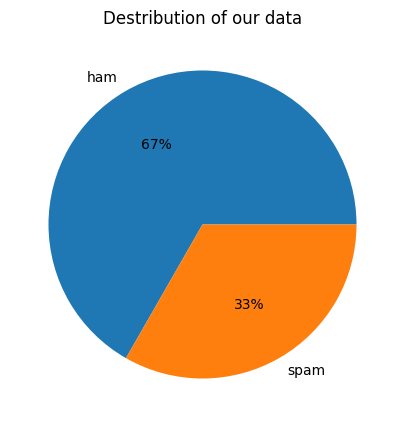

In [ ]:
data_viz = [len(ham_emails), len(spam_emails)]
labels = ['ham', 'spam']
colors = ['green', 'red']
plt.figure(figsize=(12, 5))
plt.pie(data_viz, labels = labels, autopct='%.0f%%')
plt.title("Destribution of our data")
plt.show()

# Data Preprocessing

## Data Cleaning

Dans cette partie, différentes étapes de normalisation sont appliquées sur le texte des e-mails, notamment la conversion en minuscules, la suppression du code HTML, le remplacement des URLs, des adresses e-mail, des nombres et du symbole du dollar par des mots spécifiques. Enfin, une étape de stemming est réalisée pour réduire les mots à leur forme de base, et les caractères non alphabétiques et les espaces supplémentaires sont supprimés. Ces prétraitements permettent de rendre les données d'e-mails plus uniformes, d'éliminer les informations spécifiques potentiellement biaisées, et de simplifier le texte pour faciliter les analyses et les classifications ultérieures.



*   Convertir en miniscule



In [ ]:
data.email =[x.lower() for x in data.email]

* Suppression des balises HTML

In [ ]:
def suppHTML(data):
  for i in range(len(data)):
      soup = BeautifulSoup(data[i], 'html.parser')
      text = soup.get_text()
      data[i] = text

suppHTML(data.email)

* Normalisation des URL

In [ ]:
def normURL(data):
  for i in range(len(data)):
      data[i] = re.sub(r'(http|https)://[^\s]*', 'httpaddr', data[i])
      data[i] = re.sub(r'www\.[^\s]*', 'httpaddr', data[i])

normURL(data.email)

* Normalisation des adresses e-mail

In [ ]:
def normEmail(data):
  for i in range(len(data)):
    data[i] = re.sub(r'\S+@\S+', 'emailaddr', data[i])

normEmail(data.email)

* Normalisation des nombres

In [ ]:
def normNumber(data):
  for i in range(len(data)):
      data[i] = re.sub(r'\d+', 'nombre', data[i])

normNumber(data.email)

* Normalisation des dollars

In [ ]:
def normDollar(data):
  for i in range(len(data)):
      data[i] = re.sub(r'\$', 'dollar', data[i])

normDollar(data.email)

* Radicalisation de mots (Word stemming)

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
stemmer = PorterStemmer()

def stem(data):
  for i in range(len(data)):
    words = nltk.word_tokenize(data[i])
    stemmed_words = [stemmer.stem(word) for word in words]
    data[i] = ' '.join(stemmed_words)

stem(data.email)

* Suppression des non-mots

In [ ]:
def noWord(data):
  for i in range(len(data)):
      data[i] = re.sub(r'\W|_',' ',data[i])
      data[i] = re.sub(r'\s+',' ',data[i]).strip()

noWord(data.email)

In [ ]:
data.email[30]

'from emailaddr tue oct nombr nombr nombr nombr nombr return path delivered to emailaddr receiv from localhost jalapeno nombre nombre nombre nombr by jmason org postfix with esmtp id nombrefnombrefnombr for tue nombr oct nombr nombr nombr nombr nombr ist receiv from jalapeno nombre nombre nombre nombr by localhost with imap fetchmail nombre nombre nombr for emailaddr single drop tue nombr oct nombr nombr nombr nombr nombr ist receiv from dogma slashnull org localhost nombre nombre nombre nombr by dogma slashnull org nombre nombre nombre nombre nombre nombr with esmtp id gnombreknombr for tue nombr oct nombr nombr nombr nombr nombr message id emailaddr to emailaddr from newscientist subject synthet vitamin boost bone growth date tue nombr oct nombr nombr nombr nombr nombr content typ text plain encoding utf nombr x spam statu no hits nombre nombr required nombre nombr tests awl version nombre nombre cv x spam level url httpaddr date not suppli the modifi form of vitamin d could be an ef

## Vocabulary construction

*   Déterminer un seuil K pour choisir les mots qui apparaissent au moins K fois dans le corpus de spam.
*   Créer une liste de vocabulaire qui contient tous les mots qui répondent au seuil K.
*   Sauvegarder la liste de vocabulaire dans un fichier vocab.txt.






In [ ]:
# Itérer sur chaque email dans la liste:
word_counts = Counter()
for email in data['email']:
   # Diviser la chaîne de l'email en une liste de mots:
    words = email.split()
    word_counts.update(words)

word_counts

Counter({'from': 37221,
         'emailaddr': 38191,
         'wed': 5458,
         'oct': 5533,
         'nombr': 285863,
         'return': 4573,
         'path': 4185,
         'delivered': 4391,
         'to': 49391,
         'receiv': 22983,
         'localhost': 10117,
         'jalapeno': 3741,
         'nombre': 162771,
         'by': 26373,
         'jmason': 1740,
         'org': 7630,
         'postfix': 5942,
         'with': 27129,
         'esmtp': 12217,
         'id': 22128,
         'nombrefnombrefnombr': 83,
         'for': 29969,
         'ist': 5094,
         'imap': 2890,
         'fetchmail': 3032,
         'single': 3032,
         'drop': 3245,
         'egwn': 1900,
         'net': 10318,
         'nsnombre': 227,
         'dogma': 4492,
         'slashnull': 4491,
         'gnombremrknombr': 1,
         'authnombre': 493,
         'nl': 571,
         'gnombreknombrefnombr': 5,
         'evv': 8,
         'kamakiriad': 37,
         'loc': 58,
         'cable': 2

In [ ]:
len(word_counts)

66388

In [ ]:
# Déterminer le seuil K
K = 20
# Créer le vocabulaire
vocab = list(set([word for word, count in word_counts.items() if count >= K]))

In [ ]:
len(vocab)

5101

In [ ]:
# Créer le fichier vide vocab.txt qui contient les mots du vocabulaire
with open("vocab.txt", "w") as f:
    f.write("")

# Enregister le vocabulaire dans le fichier
vocab_file = open("vocab.txt", "w")
for word in vocab:
    vocab_file.write(word + "\n")
vocab_file.close()


*   Chercher chaque mot dans la liste de vocabulaire et trouver son index.
*   Si le mot est dans le vocabulaire, ajouter son index à une liste d'index de mots.
*   Si le mot n'est pas dans le vocabulaire, ignorer le mot.






In [ ]:
def email_indexation(email):
    result = []
    words = email.split()
    for word in words:
        try:
          index = vocab.index(word)
          result.append(index)
        except:
          pass

    return np.array(result)

## Extraction de caractéristiques


Dans cette partie, on s'intéresse à faire des représentations de nos données plus adaptée pour travailler avec les éventuels modèles d'entrainement. On effectue donc deux types de représentations : une représentation binaire et une représentation par comptage.

La fonction binary_representation prend un e-mail en entrée et utilise la fonction email_indexation pour obtenir les indices des mots présents dans un e-mail. Ensuite, elle initialise un tableau de zéros de la même taille que le vocabulaire global (représenté par la variable vocab). Les indices correspondant aux mots présents dans l'e-mail sont mis à 1 dans le tableau résultant, tandis que les autres indices restent à zéro. Enfin, le résultat est renvoyé sous forme de liste.

In [ ]:
def binary_representation(email):
    email_indices = email_indexation(email)
    result = np.zeros(len(vocab) , dtype=int)
    result[email_indices] = 1
    return result.tolist()

La fonction counter_representation fonctionne de manière similaire à binary_representation, mais au lieu de simplement mettre à 1 les indices correspondant aux mots présents, elle utilise la fonction np.bincount() pour compter le nombre d'occurrences de chaque mot dans l'e-mail. Le résultat est renvoyé sous forme de liste.

In [ ]:
def counter_representation(email):
    email_indices = email_indexation(email)
    result = np.bincount(email_indices, minlength=len(vocab))
    return result.tolist()

On applique la transformation en représentation binaire à notre dataframe, et on le stocke dans binary_emails


In [ ]:
def all_emails_binary():
    result = data.copy()
    for index , email in enumerate(result.email):
        result.email[index] = binary_representation(email)

    return result


In [ ]:
binary_emails = all_emails_binary()

In [ ]:
print(binary_emails)

                                                  email label
0     [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, ...   ham
1     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   ham
2     [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  spam
3     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   ham
4     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...   ham
...                                                 ...   ...
4193  [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...   ham
4194  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   ham
4195  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...   ham
4196  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...   ham
4197  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   ham

[4198 rows x 2 columns]


On applique la transformation en représentation par comptage à notre dataframe, et on le stocke dans counter_emails

In [ ]:
def all_emails_counter():
    result = data.copy()
    for index , email in enumerate(result.email):
        result.email[index] = counter_representation(email)

    return result

In [ ]:
counter_emails = all_emails_counter()

In [ ]:
print(counter_emails)

                                                  email label
0     [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, ...   ham
1     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   ham
2     [3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  spam
3     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   ham
4     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...   ham
...                                                 ...   ...
4193  [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...   ham
4194  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   ham
4195  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...   ham
4196  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...   ham
4197  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   ham

[4198 rows x 2 columns]


# Construction des  modèles

Afin d'effectuer la clasification en "spam" ou en "ham", nous avons opté pour deux modèles d'apprentissage automatique, qui sont le Naive Bayes et le SVM, et deux modèles d'apprentissage profond qui sont LSTM et CNN.

D'abord, on récupère nos données X et Y

In [ ]:
x_binary = binary_emails['email'].values
x_counter = counter_emails['email'].values
y = data['label'].values

## **Modèles d'apprentissage automatique**

In [ ]:
# Séparation des caractéristiques et des étiquettes pour le dataframe binary_emails
X_binary = binary_emails['email'].tolist()
y_binary = binary_emails['label'].tolist()

In [ ]:
# Séparation des caractéristiques et des étiquettes pour le dataframe counter_emails
X_count = counter_emails['email'].tolist()
y_count = counter_emails['label'].tolist()

In [ ]:
# Conversion des étiquettes en valeurs numériques (0 et 1)
label_encoder = LabelEncoder()
y_binary = label_encoder.fit_transform(y_binary)
y_count = label_encoder.fit_transform(y_count)

### **Naive Bayes**

In [ ]:
# Fractionner les données entre données de train et de test (0.8 pour l'entrainement et 0.2 pour le test)
X_train, X_test, y_train, y_test = train_test_split(X_binary, y_binary, test_size=0.2, random_state=42)

In [ ]:
# Instanciation et ajustement du modèle
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

In [ ]:
# Prédictions sur les données de test
y_pred = model.predict(X_test)

In [ ]:
# Caclculer l'accuracy et le classification report
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:")
print(report)

Accuracy: 0.9821428571428571
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       543
           1       0.97      0.98      0.97       297

    accuracy                           0.98       840
   macro avg       0.98      0.98      0.98       840
weighted avg       0.98      0.98      0.98       840



Visualisation de ROC, Precision-Recall et la matrice de précision

In [ ]:
y_true = y_test  # True labels
class_probabilities = model.predict_proba(X_test)  # Class probabilities

# Precision Matrix
y_pred = model.predict(X_test)  # Predicted labels
cm = confusion_matrix(y_true, y_pred)
precision_matrix = cm / cm.sum(axis=0, keepdims=True)
print("Precision Matrix:")
print(precision_matrix)

Precision Matrix:
[[0.98888889 0.03      ]
 [0.01111111 0.97      ]]


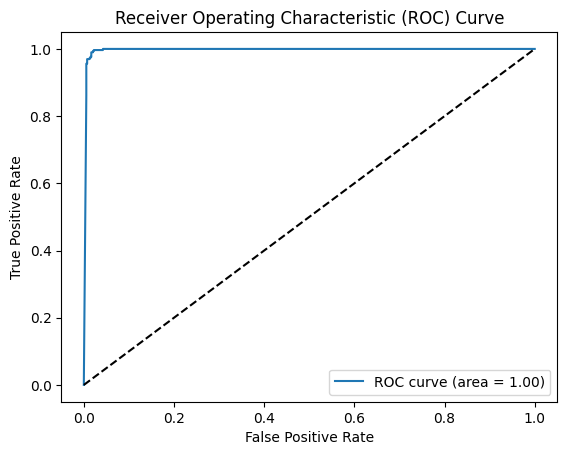

In [ ]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, class_probabilities[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

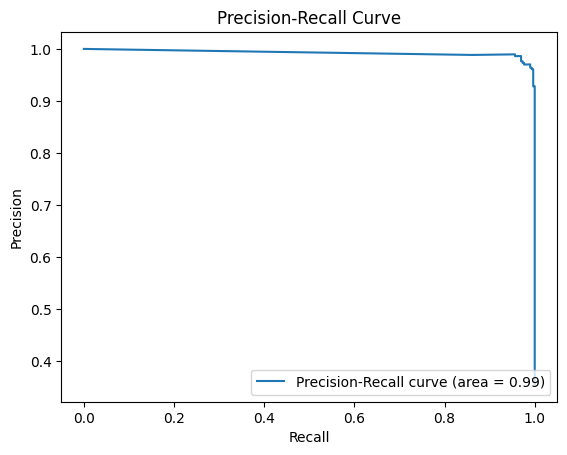

In [ ]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, class_probabilities[:, 1])
pr_auc = auc(recall, precision)

plt.figure()
plt.plot(recall, precision, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

D'après les résultats obtenus, avec 0.989 d'accuracy, nous pouvons dire que notre modèle est performant pour effectuer la classification des emails.

### **Modèle SVM**

Pour ce modèle, nous effectuer deux entrainements, un sur le dataset sur lequel on a effectué la représentation binaire donc binary_emails, et un sur le dataset avec la représentation par comptage donc counter_emails.


1.   Avec binary_emails



In [ ]:
# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_binary, y_binary, test_size=0.2, random_state=42)

# Instanciation et ajustement du modèle SVM
model = SVC()
model.fit(X_train, y_train)

# Prédictions sur les données de test
y_pred = model.predict(X_test)

In [ ]:
# Caclculer l'accuracy et le classification report
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:")
print(report)

Accuracy: 0.9952380952380953
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       543
           1       1.00      0.99      0.99       297

    accuracy                           1.00       840
   macro avg       1.00      0.99      0.99       840
weighted avg       1.00      1.00      1.00       840



Visualisation de ROC, Precision-Recall et la matrice de précision

In [ ]:
confidence_scores = model.decision_function(X_test)  # Confidence scores

# Precision Matrix
cm = confusion_matrix(y_true, y_pred)
precision_matrix = cm / cm.sum(axis=0, keepdims=True)
print("Precision Matrix:")
print(precision_matrix)

Precision Matrix:
[[0.99449541 0.00338983]
 [0.00550459 0.99661017]]


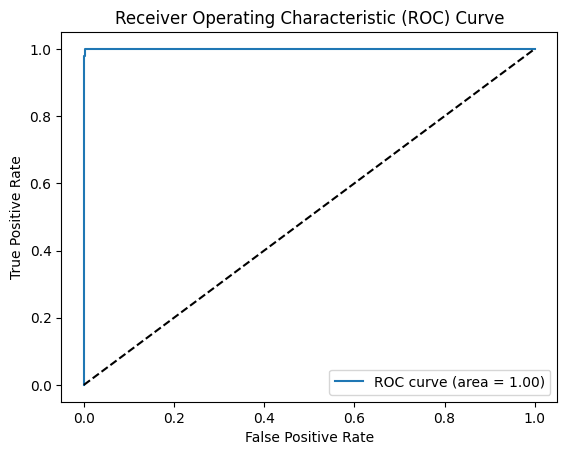

In [ ]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, confidence_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

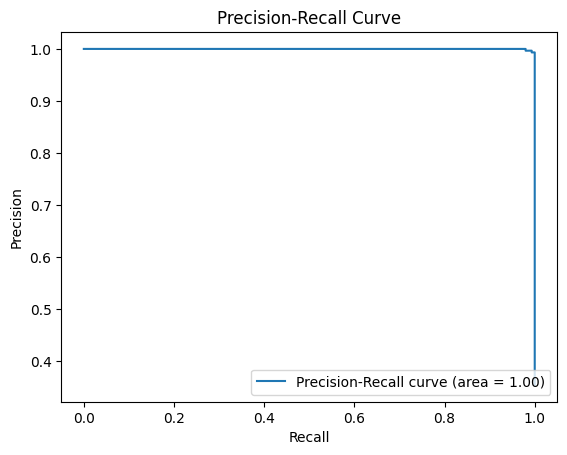

In [ ]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, confidence_scores)
pr_auc = auc(recall, precision)

plt.figure()
plt.plot(recall, precision, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()


2.   Avec counter_emails

In [ ]:
# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_count, y_count, test_size=0.2, random_state=42)


# Instanciation et ajustement du modèle SVM
model = SVC()
model.fit(X_train, y_train)

# Prédictions sur les données de test
y_pred = model.predict(X_test)

In [ ]:
# Caclculer l'accuracy et le classification report
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:")
print(report)

Accuracy: 0.9785714285714285
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       543
           1       0.98      0.96      0.97       297

    accuracy                           0.98       840
   macro avg       0.98      0.97      0.98       840
weighted avg       0.98      0.98      0.98       840



Visualisation de ROC, Precision-Recall et la matrice de précision

In [ ]:
confidence_scores = model.decision_function(X_test)  # Confidence scores

# Precision Matrix
cm = confusion_matrix(y_true, y_pred)
precision_matrix = cm / cm.sum(axis=0, keepdims=True)
print("Precision Matrix:")
print(precision_matrix)


Precision Matrix:
[[0.97640653 0.01730104]
 [0.02359347 0.98269896]]


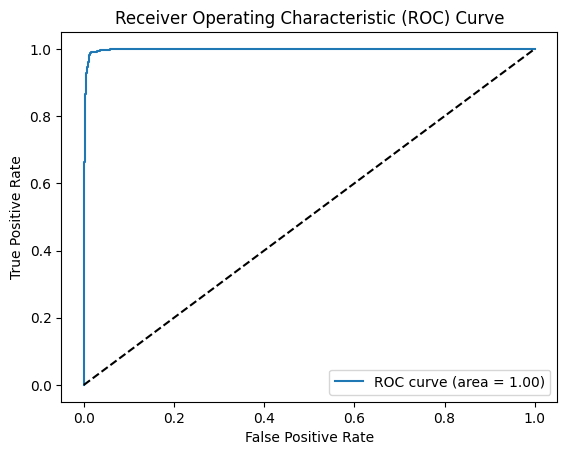

In [ ]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, confidence_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

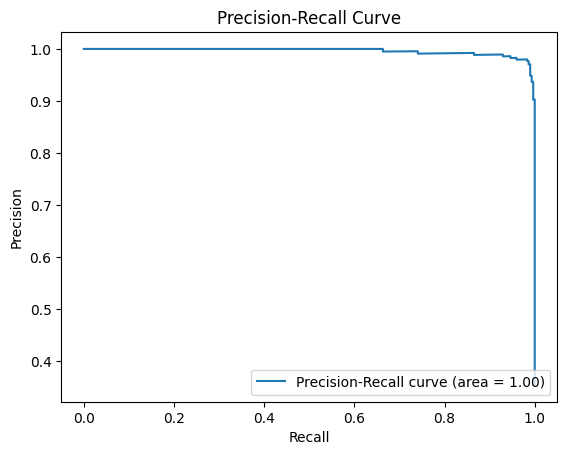

In [ ]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, confidence_scores)
pr_auc = auc(recall, precision)

plt.figure()
plt.plot(recall, precision, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

## **Modèles d'apprentissage profond**

Nous utilisons les deux modèles LSTM et CNN.
D'abord, nous mettons nos étiquettes en format binaire, 0 ou 1 au lieu de spam ou ham

In [ ]:
label_dict = {"ham": 0, "spam": 1}
ytrain = [label_dict[label] for label in y]
ytrain=np.array(ytrain)

In [ ]:
xtrain = x_binary
xtrain=np.array(xtrain)
xtrain.shape

(4198,)

In [ ]:
xtrain = np.array([np.array(lst) for lst in xtrain])
xtrain = np.reshape(xtrain, (xtrain.shape[0], len(vocab)))
xtrain.shape

(4198, 5101)

La fonction loss_epoch permet de faire une visualisation du training loss et validation loss dans chaque epoch pour les modèles d'apprentisagge profond : LSTM et CNN.

In [ ]:
def loss_epoch(model):
    training_loss = model.history.history['loss']
    test_loss = model.history.history['val_loss']
    # Create count of the number of epochs
    epoch_count = range(1, len(training_loss) + 1)

    # Visualize loss history
    plt.plot(epoch_count, training_loss, 'r--')
    plt.plot(epoch_count, test_loss, 'b-')
    plt.legend(['Training Loss', 'Validation Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title("")
    plt.show()

### LSTM

In [ ]:
time_steps = 1  # Number of time steps
input_features = xtrain.shape[1]  # Number of input features

xtrainLstm = np.reshape(xtrain, (xtrain.shape[0], time_steps, input_features))

In [ ]:
xtrainLstm  = xtrainLstm .astype('float32')

* Modele


Couche LSTM : Le modèle commence par une couche LSTM qui a 32 unités, ce qui détermine la dimension de l'espace de sortie.

Couche Dropout : Pour prévenir le surajustement, une couche de dropout avec un taux de dropout de 0,2 est ajoutée après la couche LSTM.

Couche Dense : La dernière couche est une couche dense avec 1 unité, représentant la sortie du modèle. Elle utilise la fonction d'activation sigmoïde, qui convient aux problèmes de classification binaire.

In [ ]:
model1 = Sequential([
    LSTM(units=32),
    Dropout(0.2),
    Dense(1, activation= 'sigmoid' )
])

In [ ]:
model1.compile(optimizer=Adam(learning_rate=0.001), loss = tf.keras.metrics.binary_crossentropy, metrics = ['accuracy'])
model1.fit(xtrainLstm,ytrain,epochs = 30 , validation_split=0.2)

Epoch 1/30
105/105 [==============================] - 13s 10ms/step - loss: 0.1208 - accuracy: 0.9607 - val_loss: 0.0316 - val_accuracy: 0.9940
Epoch 2/30
105/105 [==============================] - 1s 5ms/step - loss: 0.0104 - accuracy: 0.9988 - val_loss: 0.0285 - val_accuracy: 0.9905
Epoch 3/30
105/105 [==============================] - 1s 7ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.0280 - val_accuracy: 0.9917
Epoch 4/30
105/105 [==============================] - 1s 8ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.0244 - val_accuracy: 0.9929
Epoch 5/30
105/105 [==============================] - 1s 8ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0259 - val_accuracy: 0.9929
Epoch 6/30
105/105 [==============================] - 1s 6ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0290 - val_accuracy: 0.9929
Epoch 7/30
105/105 [==============================] - 1s 6ms/step - loss: 9.6230e-04 - accuracy: 1.0000 - val_loss: 0.0283 - val_accuracy: 0.9929


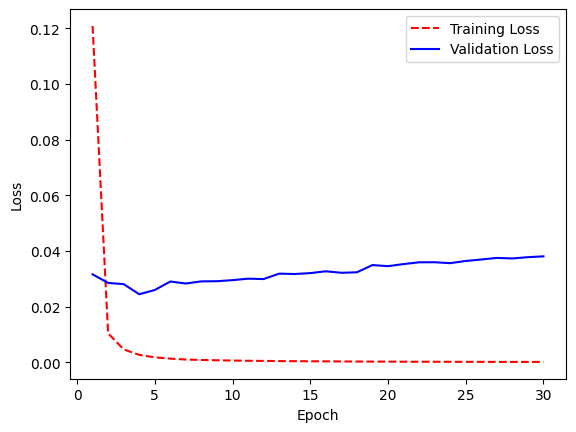

In [ ]:
loss_epoch(model1)

### Modèle CNN

In [ ]:
xtrainCnn = xtrain.reshape((xtrain.shape[0], xtrain.shape[1], 1))



*   Modele



Le choix des parametres de chaque couche dans le modèle CNN est très important, voici ceux qui nous ont donné les meilleurs résultats :

Couche de convolution 1D (Conv1D) :

*   Nombre de filtres : la couche aura 32 filtres différents pour extraire différentes caractéristiques de l'entrée.
*   Taille du noyau : Chaque filtre de convolution parcourra une fenêtre de taille 3 dans l'entrée pour extraire les caractéristiques locales.
* Activation : 'relu'. La fonction d'activation ReLU est utilisée pour introduire la non-linéarité dans la sortie de cette couche.

Couche de pooling (MaxPooling1D) :
* Taille du pool : 2. Cette couche réduit la taille spatiale des caractéristiques en prenant la valeur maximale dans chaque fenêtre de taille 2.

Deuxième couche de convolution 1D (Conv1D) :
* Nombre de filtres : 64. Cette couche a 64 filtres pour extraire davantage de caractéristiques complexes des caractéristiques extraites par la première couche de convolution.
* Taille du noyau : 3. Comme précédemment, chaque filtre parcourt une fenêtre de taille 3 dans l'entrée.
* Activation : 'relu'. La fonction d'activation ReLU est également utilisée ici.

Deuxième couche de pooling (MaxPooling1D) :
* Taille du pool : 2. De nouveau, cette couche réduit la taille spatiale des caractéristiques en prenant la valeur maximale dans chaque fenêtre de taille 2.
Troisième couche de convolution 1D (Conv1D) :
* Nombre de filtres : 64. Cette couche a 64 filtres pour extraire des caractéristiques plus complexes des caractéristiques précédentes.
Taille du noyau : 3. Chaque filtre parcourt une fenêtre de taille 3 dans l'entrée.
* Activation : 'relu'. La fonction d'activation ReLU est utilisée ici.

Aplatissement (Flatten) :
Cette couche transforme les caractéristiques en un vecteur 1D pour préparer l'entrée à la couche dense suivante.

Couche dense (Dense) :
* Nombre d'unités : 64. Cette couche est entièrement connectée avec 64 neurones.
* Activation : 'relu'. La fonction d'activation ReLU est utilisée ici pour introduire de la non-linéarité.

Couche de sortie (Dense) :
* Nombre d'unités : 1. Cette couche a un seul neurone, car il s'agit d'un problème de classification binaire.
* Activation : 'sigmoid'. La fonction d'activation sigmoïde est utilisée pour produire une probabilité de classe positive entre 0 et 1.

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(32, 3, activation='relu', input_shape=(xtrain.shape[1], 1)),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Conv1D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Conv1D(64, 3, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(xtrainCnn, ytrain, epochs=30, validation_split=0.2)

Epoch 1/30
105/105 [==============================] - 11s 19ms/step - loss: 0.0900 - accuracy: 0.9666 - val_loss: 0.0772 - val_accuracy: 0.9655
Epoch 2/30
105/105 [==============================] - 1s 14ms/step - loss: 0.0159 - accuracy: 0.9946 - val_loss: 0.0279 - val_accuracy: 0.9940
Epoch 3/30
105/105 [==============================] - 2s 15ms/step - loss: 0.0038 - accuracy: 0.9985 - val_loss: 0.0395 - val_accuracy: 0.9940
Epoch 4/30
105/105 [==============================] - 1s 14ms/step - loss: 4.5891e-04 - accuracy: 1.0000 - val_loss: 0.0313 - val_accuracy: 0.9929
Epoch 5/30
105/105 [==============================] - 2s 15ms/step - loss: 2.2689e-04 - accuracy: 1.0000 - val_loss: 0.0347 - val_accuracy: 0.9917
Epoch 6/30
105/105 [==============================] - 1s 14ms/step - loss: 1.8680e-04 - accuracy: 1.0000 - val_loss: 0.0364 - val_accuracy: 0.9917
Epoch 7/30
105/105 [==============================] - 2s 15ms/step - loss: 1.5788e-04 - accuracy: 1.0000 - val_loss: 0.0375 - val

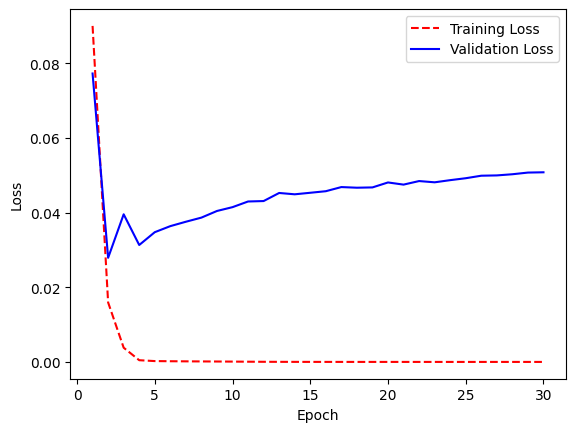

In [ ]:
loss_epoch(model)

### Etude comparative des performances des quatre modèles

Après observation des résultats obtenus par chacun des moddèles, nous pouvons résumer l'accuracy de chaque modèle dans le tableau ci-dessous :

| Modèle    |Naive Bayes| SVM Binary| SVM Counter| LSTM      | RN (CNN)  |
| --------- | --------- | --------- | ---------  | --------- | --------- |
| Accuracy  | 0.9880    | 0.9952    |  0.9797    | 0.9929    | 0.9964    |

Nous pouvons conclure donc que tous les modèles utilisés donnent de très bon résultats pour classifier les emails en "spam" ou en "ham", et que la représentation par comptage de raporte pas d'amélioration comme on peut le voir avec le modèle SVM



